In [1]:
import os
from pathlib import Path
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(666)

In [2]:
def load_data_img(path, classes, img_size=32):
    """ load image dataset
    Input:
        path: [str] path of dir which contains the subfolders of different classes' images
        classes: [list] class names
    Return:
        X: (n, d), data matrix
        Y: (n, ), corresponding label
    """
    if os.path.exists(path + 'X.npy'):
        X = np.load(path + 'X.npy')
        Y = np.load(path + 'Y.npy')
        return X, Y

    X, Y = [], []
    for y, cls in enumerate(classes):
        data_path = Path(path + cls)
        for p in data_path.iterdir():
            img = ImageOps.grayscale(Image.open(f"{p}"))
            img = img.resize((img_size, img_size))
            x = np.array(img).flatten()
            X.append(x)
            Y.append(y)

    X, Y = np.array(X), np.array(Y)
    np.save(path + 'X.npy', X)
    np.save(path + 'Y.npy', Y)

    return X, Y


def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


def cal_loss(pred, Y_onehot):
    """ calculate multinomial logistic regression loss
    Input:
        pred: (n, K), softmax output
        Y_onehot: (n, K), onehot label
    Output:
        logistic loss
    """
    return - np.mean(np.log(np.sum(np.multiply(pred, Y_onehot), axis=1)))


def plot_losses_and_accuracies(train_losses_gd, test_losses_gd, train_accuracies_gd, test_accuracies_gd,
                               train_losses_agd, test_losses_agd, train_accuracies_agd, test_accuracies_agd,
                               plt_title=None):
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_gd, label='GD Train Loss')
    plt.plot(test_losses_gd, label='GD Test Loss')
    plt.plot(train_losses_agd, label='AGD Train Loss')
    plt.plot(test_losses_agd, label='AGD Test Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if plt_title:
        plt.title("Losses for " + plt_title)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies_gd, label='GD Train Accuracy')
    plt.plot(test_accuracies_gd, label='GD Test Accuracy')
    plt.plot(train_accuracies_agd, label='AGD Train Accuracy')
    plt.plot(test_accuracies_agd, label='AGD Test Accuracy')
    plt.title('Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    if plt_title:
        plt.title("Accuracies for " + plt_title)
    plt.show()



### Coffee Dataset

In [3]:
# ============ code for loading coffee dataset ============
classes = ['Dark', 'Green', 'Light', 'Medium']
X, Y = load_data_img('coffee/train/', classes)
X_test, Y_test = load_data_img('coffee/test/', classes)
n, n_test = X.shape[0], X_test.shape[0]

In [4]:
# normalize data
mean, std = X.mean(axis=0), X.std(axis=0)
X = (X - mean) / std
X_test = (X_test - mean) / std

inlcude_bias = True
optimizers = ['gd', 'agd']

if inlcude_bias:
    X = np.concatenate([X, np.ones(shape=(n, 1))], axis=1)
    X_test = np.concatenate([X_test, np.ones(shape=(n_test, 1))], axis=1)

d = X.shape[1]
K = np.max(Y) + 1
Y_onehot = np.eye(K)[Y]  # (n, K)
Y_test_onehot = np.eye(K)[Y_test]  # (n', K)

# hyperparameters
mu = 5e-2
epochs = 1000

epoch:0, train_loss:1.38629, test_loss:1.38629, test_acc:0.2500, train_acc:0.2500
epoch:5, train_loss:1.17435, test_loss:1.19132, test_acc:0.5400, train_acc:0.5400
epoch:10, train_loss:0.93005, test_loss:1.01476, test_acc:0.6025, train_acc:0.6050
epoch:15, train_loss:0.99807, test_loss:0.99454, test_acc:0.6175, train_acc:0.6317
epoch:20, train_loss:0.89202, test_loss:0.99428, test_acc:0.6450, train_acc:0.6425
epoch:25, train_loss:0.81125, test_loss:0.79954, test_acc:0.6700, train_acc:0.6733
epoch:30, train_loss:0.74615, test_loss:0.82297, test_acc:0.6775, train_acc:0.6725
epoch:35, train_loss:0.72585, test_loss:0.70938, test_acc:0.6975, train_acc:0.6958
epoch:40, train_loss:0.67100, test_loss:0.73832, test_acc:0.6925, train_acc:0.6983
epoch:45, train_loss:0.65762, test_loss:0.63737, test_acc:0.7075, train_acc:0.7142
epoch:50, train_loss:0.61431, test_loss:0.67374, test_acc:0.7150, train_acc:0.7217
epoch:55, train_loss:0.60586, test_loss:0.58314, test_acc:0.7200, train_acc:0.7342
epoch:

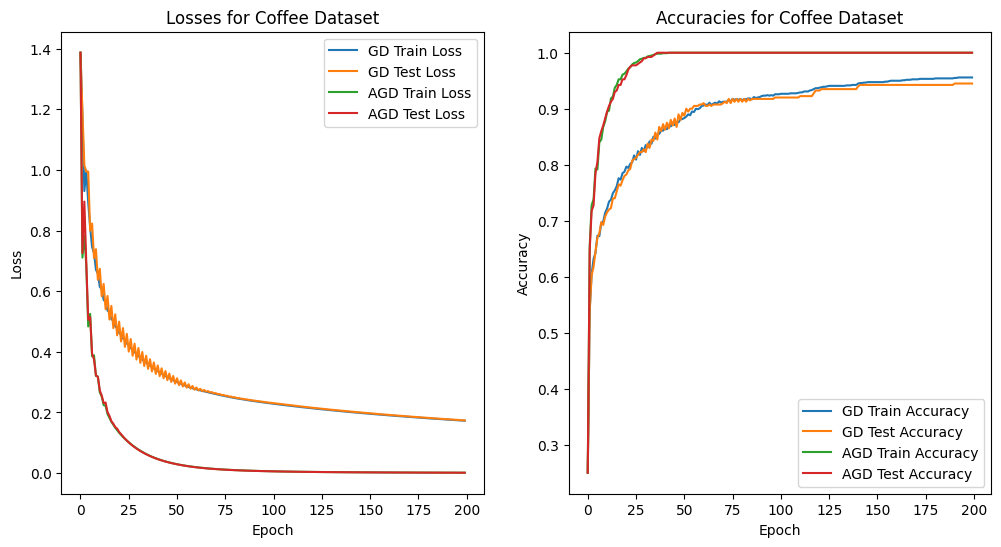

In [5]:
# initialization
Theta = np.zeros(shape=(d, K))

# train
for opt in optimizers:
    Theta = np.zeros(shape=(d, K), dtype=np.float64)
    w = np.zeros(shape=(d, K), dtype=np.float64)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):

        # evaluate
        if epoch % 5 == 0:
            pred_train = softmax(np.matmul(X, Theta))  # (n, K)
            train_loss = cal_loss(pred_train, Y_onehot)
            train_losses.append(train_loss)
            pred_test = softmax(np.matmul(X_test, Theta))  # (n', K)
            test_loss = cal_loss(pred_test, Y_test_onehot)
            test_losses.append(test_loss)

            test_acc = np.sum(pred_test.argmax(axis=1) == Y_test) / n_test
            test_accuracies.append(test_acc)
            train_acc = np.sum(pred_train.argmax(axis=1) == Y) / n
            train_accuracies.append(train_acc)

            print(
                f"epoch:{epoch}, train_loss:{train_loss:.5f}, test_loss:{test_loss:.5f},"
                f" test_acc:{test_acc:.4f}, train_acc:{train_acc:.4f}")

        # Accelerated gradient descent
        if opt == 'agd':
            temp = Theta.copy()
            Theta = w - (1 / n) * mu * np.matmul(X.T, (-Y_onehot + softmax(np.matmul(X, w))))
            w = Theta + (epoch / (epoch + 3)) * (Theta - temp)
            train_loss_agd, test_loss_agd, train_acc_agd, test_acc_agd = (
                train_losses, test_losses, train_accuracies, test_accuracies)

        # Gradient descent
        elif opt == 'gd':
            Theta += -1 * (1 / n) * mu * np.matmul(X.T, (-Y_onehot + softmax(np.matmul(X, Theta))))
            train_loss_gd, test_loss_gd, train_acc_gd, test_acc_gd = (
                train_losses, test_losses, train_accuracies, test_accuracies)

# Plot the results
plot_losses_and_accuracies(train_loss_gd, test_loss_gd, train_acc_gd, test_acc_gd,
                           train_loss_agd, test_loss_agd, train_acc_agd, test_acc_agd, plt_title='Coffee Dataset')


In [6]:
import numpy as np

# Convert lists to numpy arrays
train_loss_gd_array = np.array(train_loss_gd)
test_loss_gd_array = np.array(test_loss_gd)

# Check if arrays are identical
are_identical = np.array_equal(train_loss_gd_array, test_loss_gd_array)

print(f"Are train_loss_gd and test_loss_gd identical? {are_identical}")

Are train_loss_gd and test_loss_gd identical? False


In [7]:
from scipy.stats import ttest_ind

# Perform t-test
t_stat, p_value = ttest_ind(train_loss_gd, test_loss_gd)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -0.2256887919208927
P-value: 0.8215593218142703


### Weather Dataset

In [8]:
# ============ code for loading weather dataset ============
classes = os.listdir('weather/dataset')
X_all, Y_all = load_data_img('weather/dataset/', classes)
data_num = X_all.shape[0]
train_idx = np.random.choice(data_num, size=int(data_num*0.8), replace=False)
test_idx = np.delete(np.arange(data_num), train_idx)
X, Y = X_all[train_idx], Y_all[train_idx]
X_test, Y_test = X_all[test_idx], Y_all[test_idx]
n, n_test = X.shape[0], X_test.shape[0]

In [9]:
# normalize data
mean, std = X.mean(axis=0), X.std(axis=0)
X = (X - mean) / std
X_test = (X_test - mean) / std

inlcude_bias = True
optimizers = ['gd', 'agd']

if inlcude_bias:
    X = np.concatenate([X, np.ones(shape=(n, 1))], axis=1)
    X_test = np.concatenate([X_test, np.ones(shape=(n_test, 1))], axis=1)

d = X.shape[1]
K = np.max(Y) + 1
Y_onehot = np.eye(K)[Y]  # (n, K)
Y_test_onehot = np.eye(K)[Y_test]  # (n', K)

# hyperparameters
mu = 2e-2
epochs = 1000

epoch:0, train_loss:1.60944, test_loss:1.60944, test_acc:0.2300, train_acc:0.1925
epoch:5, train_loss:1.22532, test_loss:1.13630, test_acc:0.6067, train_acc:0.5308
epoch:10, train_loss:1.18688, test_loss:1.09362, test_acc:0.6233, train_acc:0.5383
epoch:15, train_loss:1.16477, test_loss:1.07295, test_acc:0.6300, train_acc:0.5425
epoch:20, train_loss:1.14828, test_loss:1.05986, test_acc:0.6433, train_acc:0.5600
epoch:25, train_loss:1.13471, test_loss:1.05045, test_acc:0.6533, train_acc:0.5692
epoch:30, train_loss:1.12295, test_loss:1.04317, test_acc:0.6467, train_acc:0.5717
epoch:35, train_loss:1.11244, test_loss:1.03725, test_acc:0.6500, train_acc:0.5767
epoch:40, train_loss:1.10285, test_loss:1.03229, test_acc:0.6600, train_acc:0.5800
epoch:45, train_loss:1.09398, test_loss:1.02803, test_acc:0.6600, train_acc:0.5858
epoch:50, train_loss:1.08570, test_loss:1.02431, test_acc:0.6633, train_acc:0.5917
epoch:55, train_loss:1.07789, test_loss:1.02103, test_acc:0.6600, train_acc:0.5950
epoch:

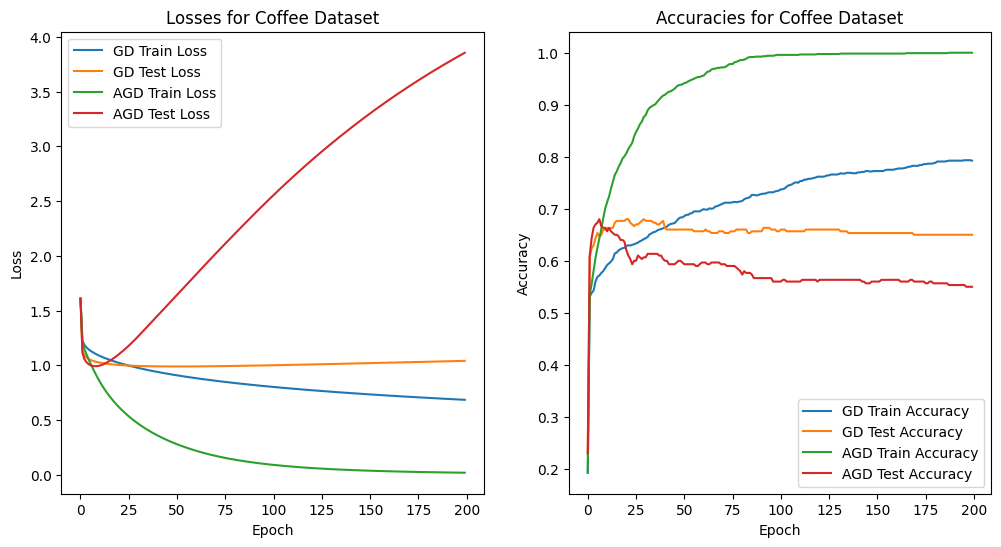

In [10]:
# initialization
Theta = np.zeros(shape=(d, K))

# train
for opt in optimizers:
    Theta = np.zeros(shape=(d, K), dtype=np.float64)
    w = np.zeros(shape=(d, K), dtype=np.float64)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):

        # evaluate
        if epoch % 5 == 0:
            pred_train = softmax(np.matmul(X, Theta))  # (n, K)
            train_loss = cal_loss(pred_train, Y_onehot)
            train_losses.append(train_loss)
            pred_test = softmax(np.matmul(X_test, Theta))  # (n', K)
            test_loss = cal_loss(pred_test, Y_test_onehot)
            test_losses.append(test_loss)

            test_acc = np.sum(pred_test.argmax(axis=1) == Y_test) / n_test
            test_accuracies.append(test_acc)
            train_acc = np.sum(pred_train.argmax(axis=1) == Y) / n
            train_accuracies.append(train_acc)

            print(
                f"epoch:{epoch}, train_loss:{train_loss:.5f}, test_loss:{test_loss:.5f},"
                f" test_acc:{test_acc:.4f}, train_acc:{train_acc:.4f}")

        # Accelerated gradient descent
        if opt == 'agd':
            temp = Theta.copy()
            Theta = w - (1 / n) * mu * np.matmul(X.T, (-Y_onehot + softmax(np.matmul(X, w))))
            w = Theta + (epoch / (epoch + 3)) * (Theta - temp)
            train_loss_agd, test_loss_agd, train_acc_agd, test_acc_agd = (
                train_losses, test_losses, train_accuracies, test_accuracies)

        # Gradient descent
        elif opt == 'gd':
            Theta += -1 * (1 / n) * mu * np.matmul(X.T, (-Y_onehot + softmax(np.matmul(X, Theta))))
            train_loss_gd, test_loss_gd, train_acc_gd, test_acc_gd = (
                train_losses, test_losses, train_accuracies, test_accuracies)

# Plot the results
plot_losses_and_accuracies(train_loss_gd, test_loss_gd, train_acc_gd, test_acc_gd,
                           train_loss_agd, test_loss_agd, train_acc_agd, test_acc_agd, plt_title='Coffee Dataset')
